# Tutuorial: Hodoscope



The `Hodoscope` class provides implementations of class simulating hodoscope-style detectors with learnable xyz positions.

I take as input the following **arguments**:

 - `init_xyz`: initial xyz position of the hodoscope in metres in the volume frame. The z position corresponds to the top of the hodoscope.

 - `init_xyz_span`: initial xyz-span (total width) of the hodoscope in metres.

 - `xyz_gap`: the gap between the edges of the hodoscope and the panels.

 - `n_panels`: the number of detection panels within the hodoscope.

 - `res`: resolution of the panels in m^-1, i.e. a higher value improves the precision on the hit recording.

 - `eff`: efficiency of the hit recording of the panel, indicated as a probability [0,1].

 - `realistic_validation`: if True, will use the physical interpretation of the panel during evaluation.
 
 - `device`: device on which to place tensors.

The panel's spans, efficiencies and resolutions are fixed parameters.

In [22]:
from volume.hodoscope import Hodoscope

hodoscope = Hodoscope(init_xyz= (0.5, 0.5, 1.5), 
                      init_xyz_span = (1., 1., .4), 
                      xyz_gap = (.1, .1, .1), 
                      n_panels = 3, 
                      eff = 0.9,
                      res = 1e3,
                      realistic_validation = False)

print("hodoscope placed at xy = {},{} [m] and z = {} [m]".format(hodoscope.xy[0].item(),
                                                                 hodoscope.xy[1].item(), 
                                                                 hodoscope.z.item() ))

hodoscope placed at xy = 0.5,0.5 [m] and z = 1.5 [m]


Once instanciated, `n_panels` detector panels are generated at $xy = $`init_xyz[:-1]`. Their $z$ position depends on the value of `xyz_gap` and the number of panels. 

In [23]:
panels = hodoscope.panels

for p in panels:
    print("Panel at z = {:.2f} [m] and x,y = {:.2f},{:.2f} [m]".format(p.z.item(), p.xy.data[0], p.xy.data[1]))

Panel at z = 1.40 [m] and x,y = 0.50,0.50 [m]
Panel at z = 1.30 [m] and x,y = 0.50,0.50 [m]
Panel at z = 1.20 [m] and x,y = 0.50,0.50 [m]


Hodoscope are meant to be placed within an instance of the `HodoscopeDetectorLayer` class. I take as input the following **arguments**:

 - `pos`: string-encoding of the detector-layer group.

 - `lw`: the length and width of the layer in the x and y axes in metres, starting from (x,y)=(0,0).

 - `z`: the z position of the top of layer in metres. The bottom of the layer will be located at z-size.

 - `size`: the voxel size in metres. Must be such that lw is divisible by the specified size.

 - `hodoscopes`: The set of initialised hodoscopes to contain in the detector layer.

Let's create the `HodoscopeDetectorLayer` placed above the passive volume, which will contained the hodoscope instanciated above:

In [24]:
import torch
from torch import Tensor

from volume.hodoscopelayer import HodoscopeDetectorLayer

hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                            lw = Tensor([2, 2]), 
                                            z = 2., 
                                            size = .9, 
                                            hodoscopes = [hodoscope])

hod_detector_above.pos

'above'

Let's create the `HodoscopeDetectorLayer` placed above the passive volume, which will contained 2 hodoscopes:

In [25]:
hodoscopes_below = [Hodoscope(init_xyz= (0.5, 0.5, z), 
                              init_xyz_span = (1., 1., .4), 
                              xyz_gap = (.1, .1, .1), 
                              n_panels = 3, 
                              eff = 0.9,
                              res = 1e3,
                              realistic_validation = False) for z in [0.1, -.3]]

hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                            lw = Tensor([2, 2]), 
                                            z = .2, 
                                            size = 1., 
                                            hodoscopes = hodoscopes_below)

hod_detector_below.pos

'below'

The two freshly created `HodoscopeDetectorLayer` can now be used to instanciate the volume:

In [26]:
from torch import nn

from tomopt.volume.layer import PassiveLayer
from tomopt.core import DEVICE

def get_layers(hod_layers):
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    layers.append(hod_layers[0])
    for z in [0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(hod_layers[1])

    return nn.ModuleList(layers)

In [27]:
from tomopt.volume.volume import Volume

volume = Volume(get_layers([hod_detector_above, hod_detector_below]))

We can now use the various draw methods to plot the volume. Here is an example with the `draw_volume_2D` method:

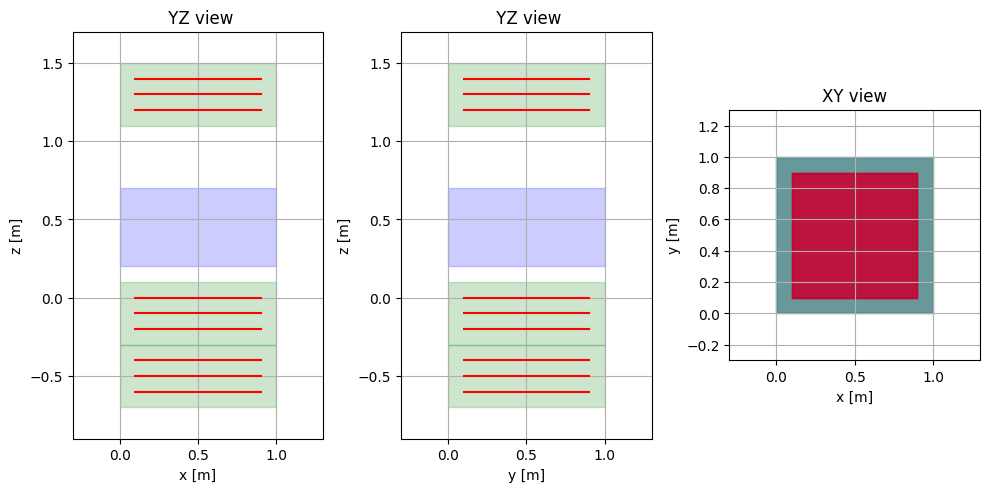

In [28]:
from plotting.plotting import draw_volume_2D
draw_volume_2D(volume)